Training a HMM
===========

Now our data is cleaned and augmented ready for training we can dive into creating our model and training it. 

Creating the model architecture
======

Going back to the first tutorial we will need to think about our observables and how they relate to our hidden states, and also how our hidden states interact with each other. For the start we'll be creating the simplest of HMM we can for our dataset. We'll take our obseravbles immobile, micro movements, and walking and assume they are governed by just 2 hidden states, asleep and awake.

We'll create a pictogram of it:

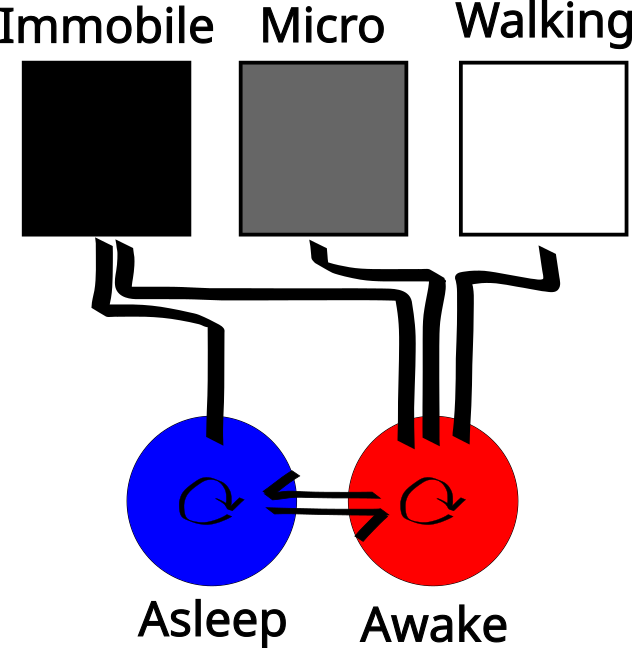

We can now translate our ideas to a starting transition matrix. When training a HMM you start with an intialised transition and emission matrix, then during the training it will make small changes to these parameters within a loop, running the forward-backward algorithm we discussed and outputting a score, which it will aim to improve. Once it has found its changes are no longer increasing the score at an a given rate it will end the training. So the intial matrix decides the starting point for the training, but it's not very important that it's close to the reality, as it will interatively update towards it during training.
For now we'll make a rough estimate of the transition rates.

In [5]:
# First we'll create lists with our state and observable names so we know their order
# Remember previously we had to convert our observable values to 0, 1, 2 and this is reflected in our list order
# Likewise with the hidden states, the output of the model when decoding observable runs will have asleep as 0 and awake as 1
observables = ['immobile', 'micro', 'walking']
hidden_states = ['asleep', 'awake']

In [8]:
import numpy as np

# Following on from the first part of the tutorial, each row in the matrix is a hidden state and each column is the hidden state it is transitioning into
# Remember the sum of each row must equal 1 and the shape is the number of states x itself. So 2 x 2
t_prob = np.array(  [[0.7, 0.3],
                    [0.2, 0.8]]
                )

# We now do the same for the emission probabilities
# Where we give it a zero value it tells the model that these emissions can't be attributed to a hidden state. So here the asleep state can only have immobile as its emission
em_prob =  np.array([[1.0, 0.0, 0.0],
                    [0.3, 0.3, 0.4],])

Inialising the model
=======

In this next section we'll generate our HMM from the hmmlearn package. The best way to fully understand a model is to look at the packages API docstrings, most pacakges will have a website page with them all. Head to this link -> [here](https://hmmlearn.readthedocs.io/en/latest/api.html#categoricalhmm) to see the docstrings for the categorical HMM, the one we'll be using.

Hmmlearn has lots of different HMM that vary with the emission type, discrete (our one) emissions is the most simple.

In [9]:
# First we import the model we want from the hmmlearn package
from hmmlearn.hmm import CategoricalHMM

In [11]:
# Simply save the model to a variable to instialise it
model = CategoricalHMM()

In [13]:
# However we're going to want to fill it with our what we've made prior, the transtion and emission matrices
# Enter the correct arguments given the docstring information below, is you don't have it put the argument as None
# model = CategoricalHMM(n_components =,  n_features = , start_prob = None, transmat =, emissionprob =, params = , init_params = )
model = CategoricalHMM(n_components = len(hidden_states),  n_features = len(observables), startprob_prior = None, transmat_prior = t_prob, emissionprob_prior = em_prob, params = 'ste', init_params = 's')

### hmmlearn docstring
CategoricalHMM(n_components=1, startprob_prior=1.0, transmat_prior=1.0, emissionprob_prior=1.0, n_features=None, algorithm='viterbi', random_state=None, n_iter=10, tol=0.01, verbose=False, params='ste', init_params='ste', implementation='log')

Hidden Markov Model with categorical (discrete) emissions.

Variables
:
n_components (int) – Number of hidden states.

n_features (int) – Number of possible symbols emitted by the model (in the samples).

startprob (array, shape (n_components, )) – Initial state occupation distribution.

transmat (array, shape (n_components, n_components)) – Matrix of transition probabilities between states.

emissionprob (array, shape (n_components, n_features)) – Probability of emitting a given symbol when in each state.

params (string, optional) – The parameters that get updated during (params) or initialized before (init_params) the training. Can contain any combination of ‘s’ for startprob, ‘t’ for transmat, and ‘e’ for emissionprob. Defaults to all parameters.

init_params (string, optional) – The parameters that get updated during (params) or initialized before (init_params) the training. Can contain any combination of ‘s’ for startprob, ‘t’ for transmat, and ‘e’ for emissionprob. Defaults to all parameters.

Preparing the data for the model
=========

In [20]:
import pandas as pd
import numpy as np

# Load the cleaned data from the previous notebook 
# df = pd.read_pickle('USERS_PATH/cleaned_data.pkl')

df = pd.read_pickle('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/admin/cleaned_data.pkl')

In [17]:
df

,id,t,moving,micro,walk,hmm
0,2016-04-04_17-38-06_019aee|07,31080,1.0,0.0,1.0,2.0
1,2016-04-04_17-38-06_019aee|07,31140,1.0,0.0,1.0,2.0
2,2016-04-04_17-38-06_019aee|07,31200,1.0,0.0,1.0,2.0
3,2016-04-04_17-38-06_019aee|07,31260,1.0,0.0,1.0,2.0
4,2016-04-04_17-38-06_019aee|07,31320,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...
9954,2016-09-27_11-30-35_009d6b|19,606300,1.0,0.0,1.0,2.0
9955,2016-09-27_11-30-35_009d6b|19,606360,0.0,0.0,0.0,0.0
9956,2016-09-27_11-30-35_009d6b|19,606420,1.0,1.0,0.0,1.0
9957,2016-09-27_11-30-35_009d6b|19,606480,1.0,0.0,1.0,2.0


In [37]:
# First we want to change our data format from pandas to numpy
# Once again call groupby with the 'hmm' column selected and this time apply a numpy array

ar_data = df.groupby('id')['hmm'].apply(np.array)

In [38]:
# Now we can make it a nested array rather than a series
ar_data = np.array(ar_data)

In [41]:
# With numpy you can check the shape of the array with .shape, we can see below that its shape is the number of flies with have in the filtered dataset
ar_data.shape

(135,)

Splitting the data into test/train
======

When training a model its important to split the dataset into a portion you train and a portion you test, as you can't score the model using the data it usesd to train the model as it will be overfitted to it.

A common technique is to use 10% of the dataset for testing post training, with the remaining 90% for the model. Many packages like [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) (a commmon machine learning package) have built in functions, but given its simplicity we'll code one ourselves.

In [43]:
# First we'll need to get the number of flies that equal 10%
test_size = 10
test_train_split = round(len(ar_data) * (test_size/100))
# Numpy random.permutations will shuffle the order
rand_runs = np.random.permutation(ar_data)
# Using square brackets after the np.array selects for arrays of a given indices 
# e.g array[0:10] would select the 1st array to the 9th, as 10 is the first array not to be included
# Not putting a number before or after the colon means either from the first or to the last array respectively 
train = rand_runs[test_train_split:]
test = rand_runs[:test_train_split]

In [44]:
# Quickly check the shape to see if it looks right 
train.shape

(121,)

In [45]:
test.shape

(14,)

Shaping the data for the model
=====

Hmmlearn needs the data shaped in a specific way for the training to work, its not too important but we'll run through it here.

In [ ]:
# First we need 
len_seq_train = [len(ar) for ar in train]
len_seq_test = [len(ar) for ar in test]

seq_train = np.concatenate(train, 0)
seq_train = seq_train.reshape(-1, 1)
seq_test = np.concatenate(test, 0)
seq_test = seq_test.reshape(-1, 1)

Going back to the first tutorial we will need to think about our observables and how they relate to our hidden states, and also how our hidden states interact with each other. In our mood example we assumed that each state could transition into each other, however biological systems are not always that free, often with certain routes state transitions must make to access others. Our example sleep could be one such. Study of sleep in mammals has shown us that sleep stages are sequential, starting with REM sleep and transtitioning through progressive deep sleep stages. If we take this as our base we are going to want to restrict our hidden states so the sleep stages are only acessed by a lighter sleep that can transition into a deep sleep.

For this tutorial we will create a 4 hidden state model where we have two sleep states and two awake states. Deep sleep, light sleep, quiet awake, active awake. Where deep sleep can only be accessed through light sleep, and active awake can only be accessed through quiet awake.

It's oten easiest to look at these transition maps in pictograms:

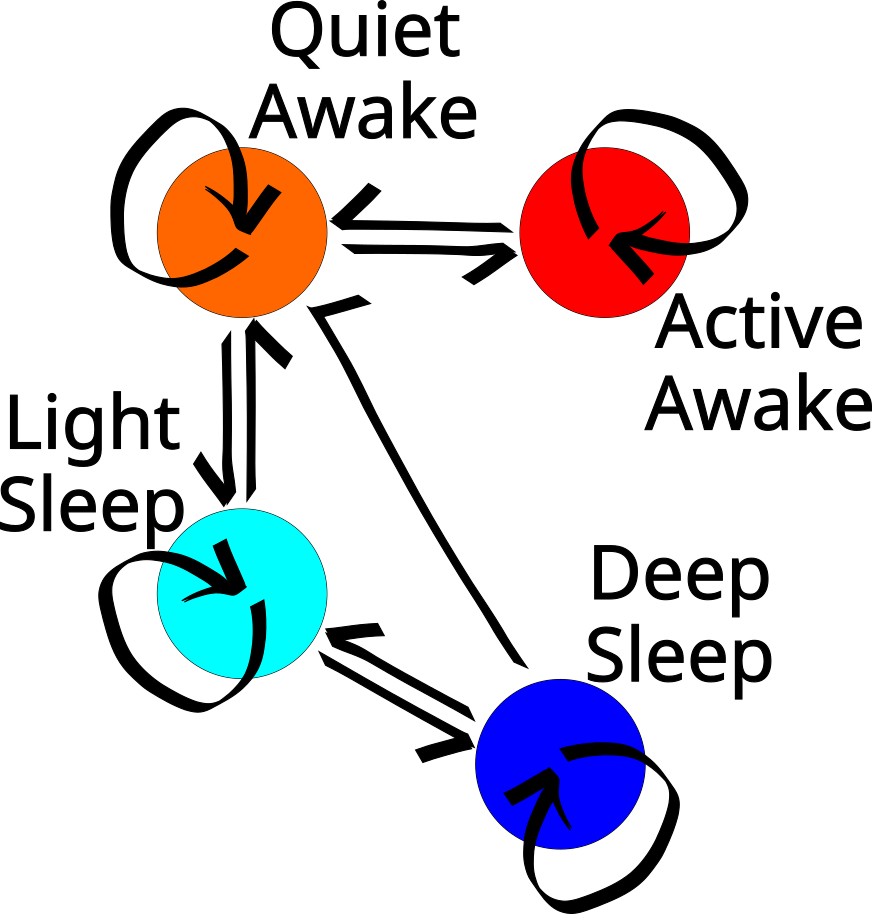

We now need to put the hidden states within context of the observables. Given the basic criteria for possible sleep is immobility we must make the model know that the observables micro movement and walking are off limits for the sleep states. Whereas the active states can have all the observables as emmissions.

Here they are added to the above pictogram:

In [ ]:
# First we'll create lists with our state and observable names so we know their order
# Remember previously we had to convert our observable values to 0, 1, 2 and this is reflected in our list order
# Likewise with the hidden states, the output of the model when decoding observable runs will have deep sleep as 0, light sleep as 1, and so on
observables = ['immobile', 'micro', 'walking']
hidden_states = ['deep sleep', 'light sleep', 'quiet awake', 'active awake']

In [ ]:
# Following on from the first part of the tutorial, each row in the matrix is a hidden state and each column is the hidden state it is transitioning into
# Where we give it a zero value it tells the model that these states can't transition into each other
# Taking the first row to be "deep sleep", the first entry is its transition probablity into itself, the next is into "light sleep", the next is "quiet awake", and finally we have its transition into "active awake"
# The next row is for "light sleep", but the columns stay the same, so the first entry is the transtion probabilty into "deep sleep", the second entry is for itself, and then so on.
# Remember the sum of each row must equal 1
t_prob = np.array([[0.6, 0.25, 0.15, 0.0],
                    [0.25, 0.6, 0.15, 0.0],
                    [0.0, 0.2, 0.5, 0.3],
                    [0.0, 0.0, 0.2, 0.8]])

# We now do the same for the emission probabilities
em_prob =  np.array([[1.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [0.2, 0.5, 0.4],
                    [0.05 0.25, 0.7]])

With the above starting transition and emission probabilities we could run the training and chose the model with the best score thinking we've got the best we could with the data and time we have. However, you can run into a machine learning problem called local minima, where if you start from the same point everytime when training the model will optimise to the best score in that local area. Whereas, in reality there are much better parameters the model misses out on, see the pciture below. If we start at the red mark and iterate new parameters it will always fall into the local minima, which has a worse score.

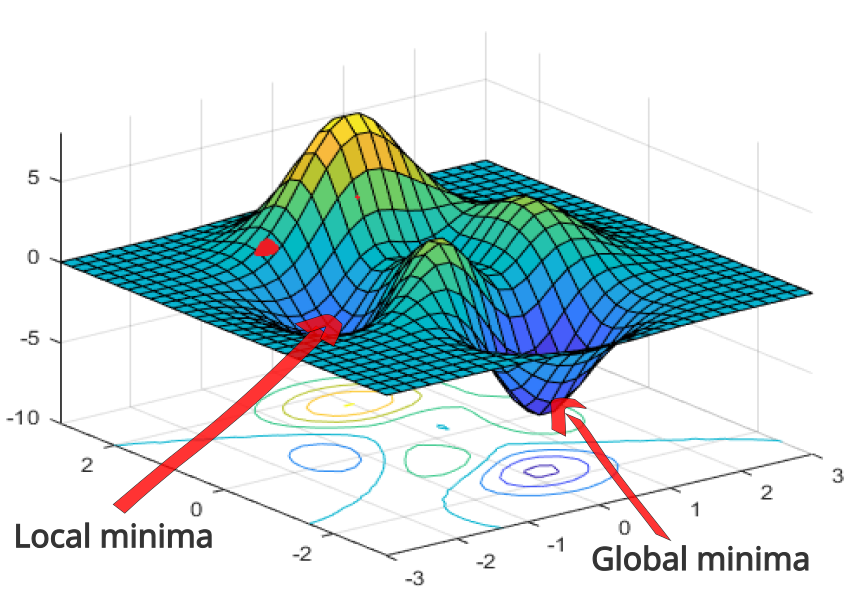

To get round this it's best to randomise your starting parameters everytime so your liklihood of finding the global minima is greater. The hmmlearn models has this built in, where if you don't set the transition probabilities beforehand it will randomise them. However, you can't tell it to keep some transmissions or emissions to be 0, losing the architecture you want. So, we'll have to make our own version of it!

In [ ]:
t_prob = np.array([['rand', 'rand', 'rand', 0.0],
                    ['rand', 'rand', 'rand', 0.0],
                    [0.0, 'rand', 'rand', 'rand'],
                    [0.0, 0.0, 'rand', 'rand']])


em_prob =  np.array([[1.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0],
                    ['rand', 'rand', 'rand'],
                    ['rand', 'rand', 'rand']])

# **TO DO**

## How to create random numbers in an array
### Outcome - how to use numpy random and to iterate through an array (list comprehension)

In [ ]:
if start_probs is None:
    init_params += 's'
else:
    s_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in start_probs], dtype = np.float64)
    s_prob = np.array([[y / sum(x) for y in x] for x in t_prob], dtype = np.float64)
    h.startprob_ = s_prob

if trans_probs is None:
    init_params += 't'
else:
    # replace 'rand' with a new random number being 0-1
    t_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in trans_probs], dtype = np.float64)
    t_prob = np.array([[y / sum(x) for y in x] for x in t_prob], dtype = np.float64)
    h.transmat_ = t_prob

if emiss_probs is None:
    init_params += 'e'
else:
    # replace 'rand' with a new random number being 0-1
    em_prob = np.array([[np.random.random() if y == 'rand' else y for y in x] for x in emiss_probs], dtype = np.float64)
    em_prob = np.array([[y / sum(x) for y in x] for x in em_prob], dtype = np.float64)
    h.emissionprob_ = em_prob

# **TO DO**

## How to intialise a model - just link it out to the API docs 
### Outcome - read a classes API and apply the learning from before to fill in the arguments

hmm.CategoricalHMM(n_components=1, startprob_prior=1.0, transmat_prior=1.0, emissionprob_prior=1.0, n_features=None, algorithm='viterbi', random_state=None, n_iter=10, tol=0.01, verbose=False, params='ste', init_params='ste', implementation='log')

Hidden Markov Model with categorical (discrete) emissions.

Variables
:
n_components (int) – Number of states.

n_features (int) – Number of possible symbols emitted by the model (in the samples).

startprob (array, shape (n_components, )) – Initial state occupation distribution.

transmat (array, shape (n_components, n_components)) – Matrix of transition probabilities between states.

emissionprob (array, shape (n_components, n_features)) – Probability of emitting a given symbol when in each state.

tol (float, optional) – Convergence threshold. EM will stop if the gain in log-likelihood is below this value.

algorithm ({"viterbi", "map"}, optional) – Decoder algorithm.

params (string, optional) – The parameters that get updated during (params) or initialized before (init_params) the training. Can contain any combination of ‘s’ for startprob, ‘t’ for transmat, and ‘e’ for emissionprob. Defaults to all parameters.

init_params (string, optional) – The parameters that get updated during (params) or initialized before (init_params) the training. Can contain any combination of ‘s’ for startprob, ‘t’ for transmat, and ‘e’ for emissionprob. Defaults to all parameters.

In [ ]:
# Fill in the arguments to initialise the model
model = hmm.CategoricalHMM(n_components =,  n_features = , algorithm = , start_prob =, transmat =, emissionprob =, tol = , algorithm =, params = , init_params = )

In [ ]:
# Load the cleaned data from the previous notebook 
df = pd.read_pickle('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/data/cleaned_data.pkl')

# **TO DO**

## Splitting the data between test and training dataset. The reshaping it to the classes specification
### Outcome -

In [ ]:
# split runs into test and train lists
test_train_split = round(len(gb) * (test_size/100))
rand_runs = np.random.permutation(gb)
train = rand_runs[test_train_split:]
test = rand_runs[:test_train_split]

In [ ]:
def reshape(dataframe):

# **TO DO**

## Run the training in a loop that saves the best model 
### Outcome - To combine all the different functions above into a for loop 
### Extra task - create a function that wraps the loop (see hmm.py for my class version)

# **TO DO**

## Viewing the output, raw vesus a formatted table 
### Outcome -

In [ ]:
hmm_display()